In [254]:
# import librarties 
import numpy as np
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
import nltk 
#import spacy
import string
import time
#import gensim
from gensim.models import KeyedVectors
from tqdm import tqdm_notebook
import os
from os import listdir 
import matplotlib.pyplot as plt 
from torch.optim import Adam
from ast import literal_eval
from datetime import datetime
from sklearn.metrics import confusion_matrix
pd.set_option('max_colwidth',100)
import matplotlib.style
import matplotlib as mpl
mpl.style.use('bmh')
#from torchsummary import summary

In [3]:
random.seed(134)
PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 64
MAX_VOCAB_SIZE = 50000
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

# Data Processing

### Build vocab from pretrained word embeddings

In [4]:
# build vocab from fasttext embeddings 

def build_vocab(word2vec_source, max_vocab_size): 
    """ Takes pretrained word2vec source path, limits to max_vocab_size, and returns:  
        - id2token: list of tokens, where id2token[i] returns token that corresponds to i-th token 
        - token2id: dictionary where keys represent tokens and corresponding values represent their indices 
        - word_emb: dictionary representing word embeddings 
    """
    word2vec_model = KeyedVectors.load_word2vec_format(word2vec_source, limit=max_vocab_size)
    id2token = word2vec_model.index2word
    token2id = dict(zip(id2token, range(2, 2+len(id2token))))
    id2token = ['<pad>', '<unk>'] + id2token 
    word_emb = {token2id[w]: word2vec_model[w] for w in word2vec_model.vocab}

    return id2token, token2id, word_emb 

In [5]:
id2token, token2id, word_emb = build_vocab('fasttext_word2vec/wiki-news-300d-1M.vec', MAX_VOCAB_SIZE)

In [6]:
# convert word_emb from dict to matrix 
pretrained_weights = np.zeros((MAX_VOCAB_SIZE+2, 300))
for idx in word_emb: 
    try: 
        pretrained_weights[idx] = word_emb[idx]
    except KeyError: 
        pretrained_weights[idx] = np.random.normal(size=(300,))
pretrained_weights = torch.from_numpy(pretrained_weights.astype(np.float32)).to(device)

### Load data and convert to indices

In [199]:
# load data into pandas dataframe 
snli_train = pd.read_table('hw2_data/snli_train.tsv')
snli_val = pd.read_table('hw2_data/snli_val.tsv')
mnli_train = pd.read_table('hw2_data/mnli_train.tsv')
mnli_val = pd.read_table('hw2_data/mnli_val.tsv')
print(len(snli_train), len(snli_val), len(mnli_train), len(mnli_val))

100000 1000 20000 5000


In [200]:
snli_train.head()

,sentence1,sentence2,label
0,A young girl in a pink shirt sitting on a dock viewing a body of water .,A young girl watching the sunset over the water .,neutral
1,A woman is smiling while the man next to her is focused on a blue object with a pattern on it .,Two people are next to each other .,entailment
2,"Across the river , you can see a large building .",The large building is full of apartments and tenants,neutral
3,a man in white shorts and a black shirt is paragliding on the ocean,A man is riding a jetski on the ocean .,contradiction
4,Four black dogs run together on bright green grass .,Four dogs are preparing to be launched into space .,contradiction


In [201]:
# helper methods to convert pandas df to lists of word indices and labels 

label_dict = {'contradiction': 0, 'neutral': 1, 'entailment': 2}

def token_to_index_datum(datum_tokens, token2id): 
    """ Converts a list of tokens and converts it to a list of token indices for one datum """ 
    index_list = [token2id[token] if token in token2id else UNK_IDX for token in datum_tokens]
    return index_list 

def df_to_list(data_df, token2id): 
    """ Takes train/val data as pandas df and returns: 
        - list of lists of word indices representing first sentence 
        - list of lists of word indices representing second sentence 
        - list of ground truth labels indicating entailment/contradiction/neutrality of two sentences 
    """
    sent1 = [token_to_index_datum(sent.split(), token2id) for sent in data_df['sentence1'].tolist()] 
    sent2 = [token_to_index_datum(sent.split(), token2id) for sent in data_df['sentence2'].tolist()] 
    labels = [label_dict[label] for label in data_df['label'].tolist()] 
    return sent1, sent2, labels

In [202]:
# convert data to indices 
snli_train_sent1, snli_train_sent2, snli_train_labels = df_to_list(snli_train, token2id)
snli_val_sent1, snli_val_sent2, snli_val_labels = df_to_list(snli_val, token2id)
mnli_train_sent1, mnli_train_sent2, mnli_train_labels = df_to_list(mnli_train, token2id)
mnli_val_sent1, mnli_val_sent2, mnli_val_labels = df_to_list(mnli_val, token2id)

Text(0,0.5,'Label')

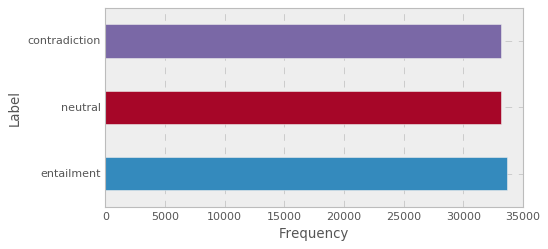

In [203]:
# check distribution of labels 
plt.figure(figsize=(6, 3))
snli_train['label'].value_counts().plot(kind='barh')
plt.xlabel('Frequency')
plt.ylabel('Label')

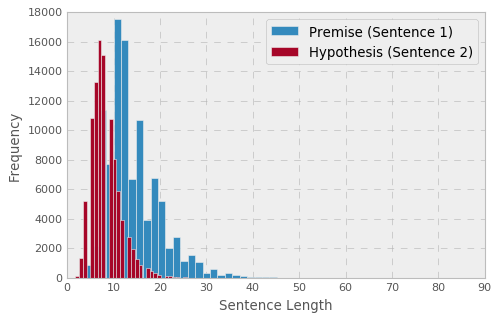

In [204]:
# check distribution of sentence lengths 
plt.figure(figsize=(6, 4))
snli_train['sentence1'].apply(lambda x: x.split()).apply(len).hist(bins=50, label='Premise (Sentence 1)')
snli_train['sentence2'].apply(lambda x: x.split()).apply(len).hist(bins=50, label='Hypothesis (Sentence 2)')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.legend()

In [205]:
# based on results above, we set our max_sentence_length to 40 which covers all of sentence2 and most of sentence1 
MAX_SENTENCE_LENGTH = 40

### Build PyTorch Dataloader 

In [206]:
# helper functions to create dataloader 

class SNLI_Dataset(Dataset): 
    """ 
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset    
    """
    
    def __init__(self, sent1_list, sent2_list, label_list): 
        """ 
        Initialize dataset by passing in the sent and label lists, along with max_sent_length 
        """
        self.sent1_list = sent1_list
        self.sent2_list = sent2_list 
        self.label_list = label_list
        assert (len(self.sent1_list) == len(self.sent2_list) == len(self.label_list))
        
    def __len__(self): 
        return len(self.label_list)
    
    def __getitem__(self, key): 
        """
        Triggered when dataset[i] is called, outputs a list of tokens, lengths of lists, and label of the data point
        """
        sent1_idx = self.sent1_list[key][:MAX_SENTENCE_LENGTH]
        sent2_idx = self.sent2_list[key][:MAX_SENTENCE_LENGTH]    
        sent1_len = len(sent1_idx)
        sent2_len = len(sent2_idx)
        label = self.label_list[key]
        return [sent1_idx, sent2_idx, sent1_len, sent2_len, label]
    
def collate_func(batch): 
    """Customized function for DataLoader that dynamically pads the batch 
       so that all data have the same length""" 
    
    sents1 = [] 
    sents2 = [] 
    sent1_lens = [] 
    sent2_lens = [] 
    labels = [] 

    for datum in batch:
        sent1_lens.append(datum[2])
        sent2_lens.append(datum[3])
        labels.append(datum[4])
        
        # pad data before appending 
        padded_vec1 = np.pad(array=np.array(datum[0]), 
                             pad_width = ((0, MAX_SENTENCE_LENGTH - datum[2])), 
                             mode = 'constant', constant_values = 0)
        padded_vec2 = np.pad(array=np.array(datum[1]), 
                             pad_width = ((0, MAX_SENTENCE_LENGTH - datum[3])), 
                             mode = 'constant', constant_values = 0)
        sents1.append(padded_vec1)
        sents2.append(padded_vec2)
        
    return [torch.from_numpy(np.array(sents1)), torch.from_numpy(np.array(sents2)), 
            torch.LongTensor(sent1_lens), torch.LongTensor(sent2_lens), torch.LongTensor(labels)]

def create_data_loader(sent1_list, sent2_list, label_list): 
    """ Takes index lists of sentence1, setence2, and labels for a given dataset and returns a data loader """
    data_set = SNLI_Dataset(sent1_list, sent2_list, label_list)
    data_loader = torch.utils.data.DataLoader(dataset=data_set, batch_size=BATCH_SIZE, 
                                              collate_fn=collate_func, shuffle=False)
    return data_loader 

In [216]:
# create data loaders 
snli_train_loader = create_data_loader(snli_train_sent1, snli_train_sent2, snli_train_labels)
snli_val_loader = create_data_loader(snli_val_sent1, snli_val_sent2, snli_val_labels)
# mnli_train_loader = create_data_loader(mnli_train_sent1, mnli_train_sent2, mnli_train_labels)
# mnli_val_loader = create_data_loader(mnli_val_sent1, mnli_val_sent2, mnli_val_labels)

In [253]:
for i, (sent1_idx, sent2_idx, sent1_len, sent2_len, label) in enumerate(snli_train_loader):
    print(i)
    print(sent1_idx)
    print(sent2_idx)
    print(sent1_len)
    print(sent2_len)
    print(label)
    break 

0
tensor([[  106,   802,  1830,  ...,     0,     0,     0],
        [  106,   994,    15,  ...,     0,     0,     0],
        [17790,     3,  1938,  ...,     0,     0,     0],
        ...,
        [ 3799,  5700,  5367,  ...,     0,     0,     0],
        [ 2129,    34, 14364,  ...,     0,     0,     0],
        [  106,  5895,   194,  ...,     0,     0,     0]])
tensor([[ 106,  802, 1830,  ...,    0,    0,    0],
        [1442,   67,   34,  ...,    0,    0,    0],
        [  22,  542,  402,  ...,    0,    0,    0],
        ...,
        [  22, 5700,   34,  ...,    0,    0,    0],
        [ 106,  347, 2784,  ...,    0,    0,    0],
        [ 106,  347, 5822,  ...,    0,    0,    0]])
tensor([17, 22, 11, 14, 10, 13, 10,  7, 18, 32, 13, 13, 30, 13, 17, 10, 26, 17,
         8, 13,  8, 13,  8, 25,  9, 15, 12,  7, 21, 10,  9, 10, 10, 10,  9, 24,
        11, 24, 16,  8,  8,  9, 15, 19, 15, 12, 10, 34, 12, 10, 22, 13,  7, 12,
        19, 16, 13,  9, 13, 20, 11, 19, 31, 30])
tensor([10,  8,  9, 1

# Model Architecture

### RNN (Single-Layer GRU)

In [61]:
# Bi-Directional GRU 

# class rnn_model(nn.Module):
#     def __init__(self, emb_size, hidden_size, num_layers, fc_out_size, num_classes, 
#                  pretrained_weights, bidirectional=True):
#         super().__init__() 
#         self.num_layers, self.hidden_size, self.bidirectional = num_layers, hidden_size, bidirectional
#         self.embedding1 = nn.Embedding.from_pretrained(pretrained_weights, freeze=True)
#         self.embedding2 = nn.Embedding.from_pretrained(pretrained_weights, freeze=True)
#         self.rnn1 = nn.GRU(emb_size, hidden_size, num_layers, bidirectional=bidirectional, batch_first=True)
#         self.rnn2 = nn.GRU(emb_size, hidden_size, num_layers, bidirectional=bidirectional, batch_first=True)
#         self.fc1 = nn.Linear(2*2*hidden_size, fc_out_size)
#         self.fc2 = nn.Linear(fc_out_size, num_classes)

#     def init_hidden(self, batch_size):
#         # Function initializes the activation of recurrent neural net at timestep 0
#         # Needs to be in format (num_layers, batch_size, hidden_size)
#         if self.bidirectional: 
#             hidden = torch.randn(self.num_layers * 2, batch_size, self.hidden_size)
#         else: 
#             hidden = torch.randn(self.num_layers, batch_size, self.hidden_size)

#         return hidden

#     def forward(self, x1, x2, x1_lengths, x2_lengths):
#         # reset hidden state

#         batch_size = x1.size()[0]

#         # run sentence 1 
#         _, idx_sort1 = torch.sort(x1_lengths, dim=0, descending=True)
#         _, idx_unsort1 = torch.sort(idx_sort1, dim=0)
#         x1, x1_lengths = x1.index_select(0, idx_sort1), x1_lengths.index_select(0, idx_sort1)
#         embed1 = self.embedding1(x1)
#         embed1 = torch.nn.utils.rnn.pack_padded_sequence(embed1, x1_lengths, batch_first=True)
#         self.hidden1 = self.init_hidden(batch_size).to(device)      
#         rnn1_out, self.hidden1 = self.rnn1(embed1, self.hidden1)
#         rnn1_out, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn1_out, batch_first=True)
#         rnn1_out_final = torch.cat([rnn1_out[:, -1, :self.hidden_size], rnn1_out[:, 0, self.hidden_size:]], dim=1) 
#         rnn1_out_final = rnn1_out_final.index_select(0, idx_unsort1)
        
#         # run sentence 2 
#         _, idx_sort2 = torch.sort(x2_lengths, dim=0, descending=True)
#         _, idx_unsort2 = torch.sort(idx_sort2, dim=0)
#         x2, x2_lengths = x2.index_select(0, idx_sort2), x2_lengths.index_select(0, idx_sort2)
#         embed2 = self.embedding2(x2)
#         embed2 = torch.nn.utils.rnn.pack_padded_sequence(embed2, x2_lengths, batch_first=True)
#         self.hidden2 = self.init_hidden(batch_size).to(device)
#         rnn2_out, self.hidden2 = self.rnn2(embed2, self.hidden2)
#         rnn2_out, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn2_out, batch_first=True)
#         rnn2_out_final = torch.cat([rnn2_out[:, -1, :self.hidden_size], rnn2_out[:, 0, self.hidden_size:]], dim=1) 
#         rnn2_out_final = rnn2_out_final.index_select(0, idx_unsort2)

#         # concat outputs from both RNNs and run them through FC layers 
#         combined = torch.cat([rnn1_out_final, rnn2_out_final], dim=1)
#         output = F.relu(self.fc1(combined))
#         logits = self.fc2(output) 

#         return logits 

In [262]:
# Bi-Directional GRU with dropout 

class rnn_model(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, fc_out_size, num_classes, 
                 pretrained_weights, bidirectional=True, dropout_fc=None):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        # vocab_size: vocabulary size
        super().__init__() 
        self.num_layers, self.hidden_size, self.bidirectional, self.dropout_fc = num_layers, hidden_size, bidirectional, dropout_fc
        self.embedding1 = nn.Embedding.from_pretrained(pretrained_weights, freeze=True)
        self.embedding2 = nn.Embedding.from_pretrained(pretrained_weights, freeze=True)
        self.rnn1 = nn.GRU(emb_size, hidden_size, num_layers, bidirectional=bidirectional, batch_first=True)
        self.rnn2 = nn.GRU(emb_size, hidden_size, num_layers, bidirectional=bidirectional, batch_first=True)
        self.fc1 = nn.Linear(2*2*hidden_size, fc_out_size)
        self.fc2 = nn.Linear(fc_out_size, num_classes)

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        if self.bidirectional: 
            hidden = torch.randn(self.num_layers * 2, batch_size, self.hidden_size)
        else: 
            hidden = torch.randn(self.num_layers, batch_size, self.hidden_size)

        return hidden

    def forward(self, x1, x2, x1_lengths, x2_lengths):
        # reset hidden state

        batch_size = x1.size()[0]

        # run sentence 1 
        _, idx_sort1 = torch.sort(x1_lengths, dim=0, descending=True)
        _, idx_unsort1 = torch.sort(idx_sort1, dim=0)
        x1, x1_lengths = x1.index_select(0, idx_sort1), x1_lengths.index_select(0, idx_sort1)
        embed1 = self.embedding1(x1)
        embed1 = torch.nn.utils.rnn.pack_padded_sequence(embed1, x1_lengths, batch_first=True)
        self.hidden1 = self.init_hidden(batch_size).to(device)      
        rnn1_out, self.hidden1 = self.rnn1(embed1, self.hidden1)
        rnn1_out, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn1_out, batch_first=True)
#        print(rnn1_out.size(), self.hidden1.size())
        rnn1_out_final = torch.cat([rnn1_out[:, -1, :self.hidden_size], rnn1_out[:, 0, self.hidden_size:]], dim=1) 
        rnn1_out_final = rnn1_out_final.index_select(0, idx_unsort1)
        
        # run sentence 2 
        _, idx_sort2 = torch.sort(x2_lengths, dim=0, descending=True)
        _, idx_unsort2 = torch.sort(idx_sort2, dim=0)
        x2, x2_lengths = x2.index_select(0, idx_sort2), x2_lengths.index_select(0, idx_sort2)
        embed2 = self.embedding2(x2)
        embed2 = torch.nn.utils.rnn.pack_padded_sequence(embed2, x2_lengths, batch_first=True)
        self.hidden2 = self.init_hidden(batch_size).to(device)
        rnn2_out, self.hidden2 = self.rnn2(embed2, self.hidden2)
        rnn2_out, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn2_out, batch_first=True)
        rnn2_out_final = torch.cat([rnn2_out[:, -1, :self.hidden_size], rnn2_out[:, 0, self.hidden_size:]], dim=1) 
        rnn2_out_final = rnn2_out_final.index_select(0, idx_unsort2)

        # concat outputs from both RNNs and run them through FC layers 
        combined = torch.cat([rnn1_out_final, rnn2_out_final], dim=1)
        if self.dropout_fc is not None: 
            combined = nn.Dropout(p=self.dropout_fc)(combined)
        output = F.relu(self.fc1(combined))
        logits = self.fc2(output) 

        return logits 

### CNN

In [62]:
# 2-layer 1D CNN with ReLU activations 

class CNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, fc_out_size, num_classes, pretrained_weights):

        super(CNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        
        self.embedding1 = nn.Embedding.from_pretrained(pretrained_weights, freeze=True)
        self.conv11 = nn.Conv1d(emb_size, hidden_size, kernel_size=3, padding=1)
        self.conv12 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)
        
        self.embedding2 = nn.Embedding.from_pretrained(pretrained_weights, freeze=True)
        self.conv21 = nn.Conv1d(emb_size, hidden_size, kernel_size=3, padding=1)
        self.conv22 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)    
        
        self.fc1 = nn.Linear(2*hidden_size, fc_out_size)
        self.fc2 = nn.Linear(fc_out_size, num_classes)

    def forward(self, x1, x2, x1_lengths, x2_lengths):
        batch_size, seq_len = x1.size()

        embed1 = self.embedding1(x1)
        hidden1 = self.conv11(embed1.transpose(1,2)).transpose(1,2)
#        hidden1 = F.leaky_relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len, hidden1.size(-1))
        hidden1 = self.conv12(hidden1.transpose(1,2)).transpose(1,2)
        hidden1 = F.leaky_relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len, hidden1.size(-1))
        #hidden1 = torch.sum(hidden1, dim=1)
        hidden1 = torch.max(hidden1, dim=1)[0]

        embed2 = self.embedding2(x2)
        hidden2 = self.conv21(embed2.transpose(1,2)).transpose(1,2)
#        hidden2 = F.leaky_relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len, hidden2.size(-1))
        hidden2 = self.conv22(hidden2.transpose(1,2)).transpose(1,2)
        hidden2 = F.leaky_relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len, hidden2.size(-1))
#        hidden2 = torch.sum(hidden2, dim=1)
        hidden2 = torch.max(hidden2, dim=1)[0]
        
        # concat outputs from both RNNs and run them through FC layers 
        combined = torch.cat([hidden1, hidden2], dim=1)
        output = F.relu(self.fc1(combined))
        logits = self.fc2(output) 
        
        return logits

# Model Training 

In [191]:
# helper functions to train and test model - old 

# def test_model(loader, model): 
#     """ 
#     Helper function that tests the model's performance on a given dataset 
#     @param: loader = data loader for the dataset to test against 
#     """
#     correct = 0 
#     total = 0 
#     model.eval() 
#     all_predictions = [] 
#     all_labels = [] 
    
#     for sent1s, sent2s, sent1_lens, sent2_lens, labels in loader: 
#         sent1s, sent2s, sent1_lens, sent2_lens, labels = sent1s.to(device), sent2s.to(device), sent1_lens.to(device), sent2_lens.to(device), labels.to(device)
#         outputs = F.softmax(model(sent1s, sent2s, sent1_lens, sent2_lens), dim=1)
#         predictions = outputs.max(1, keepdim=True)[1]    
#         total += labels.size(0)
#         correct += predictions.eq(labels.view_as(predictions)).sum().item()
#         all_predictions += list(predictions.flatten()) 
#         all_labels += list(labels.flatten())
        
#     return (100 * correct / total), all_predictions, all_labels 


# def train_and_eval(model, train_loader, val_loader, num_epochs, learning_rate, print_intermediate=True, 
#                    save_checkpoint=False, model_name='default'):  
#     """
#     Trains model on data from train_loader and evaluates on data from val_loader for num_epochs 
#     Returns results as a dictionary comprising epoch, train accuracy, and validation accuracy 
#     """
#     # train and validate 
#     criterion = torch.nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
#     results = []
#     for epoch in range(num_epochs):
#         for i, (sent1s, sent2s, sent1_lens, sent2_lens, labels) in enumerate(train_loader):
#             model.to(device)
#             model.train()
#             optimizer.zero_grad()
#             sent1s, sent2s, sent1_lens, sent2_lens, labels = sent1s.to(device), sent2s.to(device), sent1_lens.to(device), sent2_lens.to(device), labels.to(device)
#             outputs = model(sent1s, sent2s, sent1_lens, sent2_lens)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             # validate every 100 iterations
#             if i % 100 == 0 or ((epoch==num_epochs-1) & (i==len(train_loader)-1)):
#                 result = {} 
#                 result['epoch'] = epoch + i / len(train_loader)
#                 result['train_acc'], _, _ = test_model(train_loader, model)
#                 result['val_acc'], _, _ = test_model(val_loader, model)       
#                 results.append(result)

#                 if save_checkpoint: 
#                     checkpoint_fp = 'model_checkpoints/{}.pth.tar'.format(model_name)
#                     torch.save(model.state_dict(), checkpoint_fp)
                
#                 if print_intermediate: 
#                     print('Epoch: {:.2f}, Train Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%'.format(
#                         result['epoch'], result['train_acc'], result['val_acc']))
#     return results 

In [192]:
# helper functions to train and test model - save model if best  

def test_model(loader, model): 
    """ 
    Helper function that tests the model's performance on a given dataset 
    @param: loader = data loader for the dataset to test against 
    """
    correct = 0 
    total = 0 
    model.eval() 
    all_predictions = [] 
    all_labels = [] 
    
    for sent1s, sent2s, sent1_lens, sent2_lens, labels in loader: 
        sent1s, sent2s, sent1_lens, sent2_lens, labels = sent1s.to(device), sent2s.to(device), sent1_lens.to(device), sent2_lens.to(device), labels.to(device)
        outputs = F.softmax(model(sent1s, sent2s, sent1_lens, sent2_lens), dim=1)
        predictions = outputs.max(1, keepdim=True)[1]    
        total += labels.size(0)
        correct += predictions.eq(labels.view_as(predictions)).sum().item()
        all_predictions += list(predictions.flatten()) 
        all_labels += list(labels.flatten())
        
    return (100 * correct / total), all_predictions, all_labels 


def train_and_eval(model, train_loader, val_loader, num_epochs, learning_rate, print_intermediate=True, 
                   save_checkpoint=False, model_name='default'):  
    """
    Trains model on data from train_loader and evaluates on data from val_loader for num_epochs 
    Returns results as a dictionary comprising epoch, train accuracy, and validation accuracy 
    """
    # train and validate 
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    results = []
    for epoch in range(num_epochs):
        for i, (sent1s, sent2s, sent1_lens, sent2_lens, labels) in enumerate(train_loader):
            model.to(device)
            model.train()
            optimizer.zero_grad()
            sent1s, sent2s, sent1_lens, sent2_lens, labels = sent1s.to(device), sent2s.to(device), sent1_lens.to(device), sent2_lens.to(device), labels.to(device)
            outputs = model(sent1s, sent2s, sent1_lens, sent2_lens)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i % 100 == 0 or ((epoch==num_epochs-1) & (i==len(train_loader)-1)):
                result = {} 
                result['epoch'] = epoch + i / len(train_loader)
                result['train_acc'], _, _ = test_model(train_loader, model)
                result['val_acc'], _, _ = test_model(val_loader, model)       
                results.append(result)

                if save_checkpoint: 
                    if result['val_acc'] == pd.DataFrame.from_dict(results)['val_acc'].max(): 
                        checkpoint_fp = 'model_checkpoints/{}.pth.tar'.format(model_name)
                        torch.save(model.state_dict(), checkpoint_fp)
                
                if print_intermediate: 
                    print('Epoch: {:.2f}, Train Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%'.format(
                        result['epoch'], result['train_acc'], result['val_acc']))
    return results 

In [193]:
# helper functions to save results to and load results from a pkl logfile 

RESULTS_LOG = 'experiment_results/experiment_results_log_v4_gcp.pkl'

def append_to_log(hyperparams, results, runtime, experiment_name, filename=RESULTS_LOG): 
    """ Appends results and details of a single experiment to a log file """
    
    # create directory if doesn't already exist 
    if not os.path.exists(os.path.dirname(filename)):
        os.makedirs(os.path.dirname(filename))
        
    # store experiment details in a dictionary 
    new_result = {'experiment_name': experiment_name, 'hyperparams': hyperparams, 'results': results, 
                  'runtime': runtime, 'dt_created': datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
    
    # if log already exists, append to log 
    try: 
        results_log = pkl.load(open(filename, "rb"))
        results_log.append(new_result)

    # if log doesn't exists, initialize first result as the log 
    except (OSError, IOError) as e:
        results_log = [new_result]
    
    # save to pickle 
    pkl.dump(results_log, open(filename, "wb"))

In [194]:
def load_experiment_log(experiment_name=None, filename=RESULTS_LOG): 
    """ Loads experiment log, with option to filter for a specific experiment_name """
    
    results_log = pkl.load(open(filename, "rb"))
    
    if experiment_name is not None: 
        results_log = [r for r in results_log if r['experiment_name'] == experiment_name]
        
    return results_log 

In [195]:
# def run_experiment(train_loader, val_loader, model_type, hidden_size, fc_out_size, kernel_size,  
#                    learning_rate, num_epochs, experiment_name='Not_Specified', 
#                    save_to_log=True, save_checkpoint=False, print_summary=True, print_intermediate=True):  
    
#     """ Wraps all processing, training and evaluation steps in a function to facilitate hyperparam tuning. 
#         Note that the function takes as input tokenized data rather than raw data since there's significant 
#         lag time in generating tokens.  
#     """
    
#     start_time = time.time() 
    
#     # instantiate model and optimizer 
#     if model_type == 'rnn': 
#         model = rnn_model(emb_size=300, hidden_size=hidden_size, num_layers=1, fc_out_size=fc_out_size, 
#                           num_classes=3, pretrained_weights=pretrained_weights)
#     elif model_type == 'cnn': 
#         model = CNN(emb_size=300, hidden_size=hidden_size, num_layers=2, fc_out_size=fc_out_size, 
#                     num_classes=3, pretrained_weights=pretrained_weights)
#     else: 
#         raise ValueError("Invalid model_type. Must be either 'cnn' or 'rnn'")
        
#     # train and evaluate 
#     results = train_and_eval(model, train_loader, val_loader, num_epochs, learning_rate, 
#                              print_intermediate=print_intermediate, save_checkpoint=save_checkpoint, 
#                              model_name=experiment_name)
    
#     # store, print, and save results 
#     runtime = time.time() - start_time 
#     hyperparams = {'model_type': model_type, 'hidden_size': hidden_size, 'fc_out_size': fc_out_size, 
#                    'kernel_size': kernel_size, 'learning_rate': learning_rate, 'num_epochs': num_epochs}
#     if save_to_log: 
#         append_to_log(hyperparams, results, runtime, experiment_name)
#     if print_summary: 
#         print("Experiment completed in {} seconds with {}% validation accuracy.".format(
#             int(runtime), pd.DataFrame.from_dict(results)['val_acc'].max()))
        
#     return results, hyperparams, runtime, model, train_loader, val_loader 

In [263]:
# with dropout 

def run_experiment(train_loader, val_loader, model_type, hidden_size, fc_out_size, kernel_size, 
                   learning_rate, num_epochs, dropout_fc=None, experiment_name='Not_Specified', 
                   save_to_log=True, save_checkpoint=False, print_summary=True, print_intermediate=True):  
    
    """ Wraps all processing, training and evaluation steps in a function to facilitate hyperparam tuning. 
        Note that the function takes as input tokenized data rather than raw data since there's significant 
        lag time in generating tokens.  
    """
    
    start_time = time.time() 
    
    # instantiate model and optimizer 
    if model_type == 'rnn': 
        model = rnn_model(emb_size=300, hidden_size=hidden_size, num_layers=1, fc_out_size=fc_out_size, 
                          num_classes=3, pretrained_weights=pretrained_weights, dropout_fc=dropout_fc)
    elif model_type == 'cnn': 
        model = CNN(emb_size=300, hidden_size=hidden_size, num_layers=2, fc_out_size=fc_out_size, 
                    num_classes=3, pretrained_weights=pretrained_weights, dropout_fc=dropout_fc)
    else: 
        raise ValueError("Invalid model_type. Must be either 'cnn' or 'rnn'")
        
    # train and evaluate 
    results = train_and_eval(model, train_loader, val_loader, num_epochs, learning_rate, 
                             print_intermediate=print_intermediate, save_checkpoint=save_checkpoint, 
                             model_name=experiment_name)
    
    # store, print, and save results 
    runtime = time.time() - start_time 
    hyperparams = {'model_type': model_type, 'hidden_size': hidden_size, 'fc_out_size': fc_out_size, 
                   'kernel_size': kernel_size, 'learning_rate': learning_rate, 'num_epochs': num_epochs}
    if save_to_log: 
        append_to_log(hyperparams, results, runtime, experiment_name)
    if print_summary: 
        print("Experiment completed in {} seconds with {}% validation accuracy.".format(
            int(runtime), pd.DataFrame.from_dict(results)['val_acc'].max()))
        
    return results, hyperparams, runtime, model, train_loader, val_loader 

In [196]:
# helper methods to summarize, evaluate, and plot results 

def summarize_results(results_log): 
    """ Summarizes results_log (list) into a dataframe, splitting hyperparameters string into columns, and reducing 
        the val_acc dict into the best validation accuracy obtained amongst all the epochs logged """
    results_df = pd.DataFrame.from_dict(results_log)
    results_df = pd.concat([results_df, results_df['hyperparams'].apply(pd.Series)], axis=1)
    results_df['val_acc'] = results_df['results'].apply(lambda d: pd.DataFrame.from_dict(d)['val_acc'].max())
    return results_df.sort_values(by='val_acc', ascending=False) 

def plot_multiple_learning_curves(results_df, plot_variable, figsize=(8, 5), legend_loc='best'):
    """ Plots learning curves of MULTIPLE experiments, includes only validation accuracy """
    plt.figure(figsize=figsize)
    for index, row in results_df.iterrows():
        val_acc_hist = pd.DataFrame.from_dict(row['results']).set_index('epoch')['val_acc'] 
        plt.plot(val_acc_hist, label="{} ({}%)".format(row[plot_variable], val_acc_hist.max()))
    plt.legend(title=plot_variable, loc=legend_loc)    
    plt.ylabel('Validation Accuracy')
    plt.xlabel('Epoch')

def plot_single_learning_curve(results, figsize=(8, 5)): 
    """ Plots learning curve of a SINGLE experiment, includes both train and validation accuracy """
    results_df = pd.DataFrame.from_dict(results)
    results_df = results_df.set_index('epoch')
    results_df.plot(figsize=figsize)
    plt.ylabel('Validation Accuracy')
    plt.xlabel('Epoch')

### Train RNN 

#### Tune hidden_size and fc_out_size together 

In [158]:
# test various combos of hidden size and fc out size 

hidden_sizes = [10, 25, 50, 100, 200]
fc_out_sizes = [100, 200, 300, 500, 750]

for hidden_size in hidden_sizes: 
    for fc_out_size in fc_out_sizes: 
        print ("Training with hidden_size = {} and fc_out_size = {} ...".format(hidden_size, fc_out_size))
    
        # train and evaluate
        results, hyperparams, runtime, _, _, _ = run_experiment(
            train_loader=snli_train_loader, val_loader=snli_val_loader,
            model_type='rnn', hidden_size=hidden_size, fc_out_size=fc_out_size, kernel_size=None, 
            learning_rate=0.001, num_epochs=10, experiment_name='RNN_hidden_fc_out_10epoch', 
            save_to_log=True, save_checkpoint=False, print_summary=True, print_intermediate=True)

In [163]:
# all results 
rnn_hidden_fc_out_size_exps = summarize_results(load_experiment_log(experiment_name='RNN_hidden_fc_out_10epoch', filename=RESULTS_LOG))
rnn_hidden_fc_out_size_exps[['hidden_size', 'fc_out_size', 'num_epochs', 'runtime', 'val_acc']].sort_values(['hidden_size', 'fc_out_size'])

,hidden_size,fc_out_size,num_epochs,runtime,val_acc
0,10,100,10,4990.122962,65.6
1,10,200,10,4986.884784,66.5
2,10,300,10,4988.352905,65.8
3,10,500,10,4971.827927,67.1
18,10,750,10,4868.989161,68.0
4,25,100,10,5142.905879,69.3
5,25,200,10,5104.477565,69.2
6,25,300,10,5092.012776,69.8
7,25,500,10,5101.603528,68.8
19,25,750,10,4958.269207,68.8


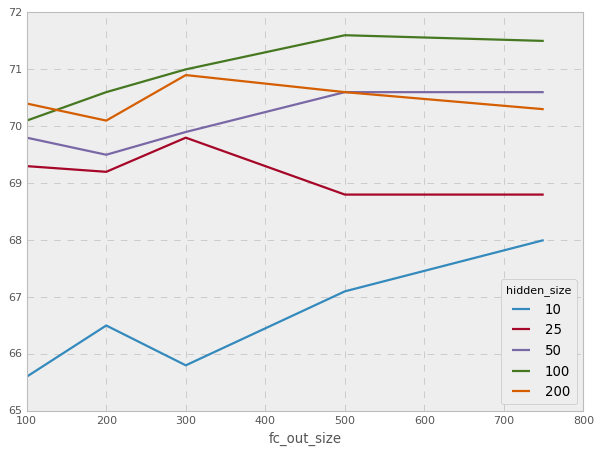

In [165]:
# plot summary results 
pd.pivot_table(rnn_hidden_fc_out_size_exps, values='val_acc', index='fc_out_size', columns='hidden_size').plot()

In [166]:
# best model 
rnn_hidden_fc_out_size_exps[['hidden_size', 'fc_out_size', 'num_epochs', 'runtime', 'val_acc']].sort_values(
    ['val_acc'], ascending=False).head(1)

,hidden_size,fc_out_size,num_epochs,runtime,val_acc
15,100,500,10,5484.221786,71.6


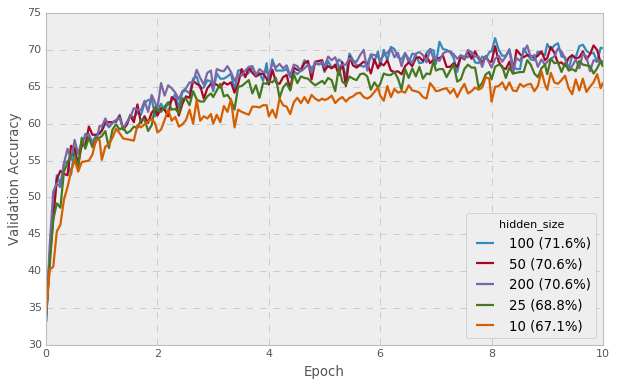

In [172]:
# ablation with hidden size (set fc_out_size = 500)
rnn_hidden_size_ablation = rnn_hidden_fc_out_size_exps[rnn_hidden_fc_out_size_exps['fc_out_size'] == 500]
plot_multiple_learning_curves(rnn_hidden_size_ablation, 'hidden_size', legend_loc='lower right')

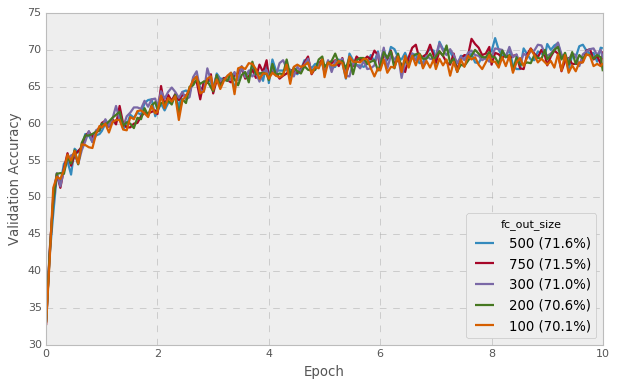

In [170]:
# ablation with fc_out_size (set hidden_size = 100)
rnn_fc_out_size_ablation = rnn_hidden_fc_out_size_exps[rnn_hidden_fc_out_size_exps['hidden_size'] == 100]
plot_multiple_learning_curves(rnn_fc_out_size_ablation, 'fc_out_size', legend_loc='lower right')

#### Test Dropout 

In [ ]:
dropout_fcs = [0.5, 0.25, 0.75, None]

for dropout_fc in dropout_fcs: 
    print ("Training with dropout_fc = {} ...".format(dropout_fc))

    # train and evaluate
    results, hyperparams, runtime, _, _, _ = run_experiment(
        train_loader=snli_train_loader, val_loader=snli_val_loader,
        model_type='rnn', hidden_size=100, fc_out_size=500, dropout_fc=dropout_fc, kernel_size=None, 
        learning_rate=0.001, num_epochs=10, experiment_name='RNN_dropout_fc_10epoch', 
        save_to_log=True, save_checkpoint=False, print_summary=True, print_intermediate=True)

In [259]:
rnn_dropout = rnn_model(emb_size=300, hidden_size=100, num_layers=1, fc_out_size=500, num_classes=3, 
                        pretrained_weights=pretrained_weights, dropout_fc=0.5)
rnn_dropout_results = train_and_eval(rnn_dropout, snli_train_loader, snli_val_loader, learning_rate=0.001, num_epochs=2, print_intermediate=True)

Epoch: 0.00, Train Accuracy: 33.60%, Validation Accuracy: 33.10%
Epoch: 0.06, Train Accuracy: 43.73%, Validation Accuracy: 41.40%
Epoch: 0.13, Train Accuracy: 48.13%, Validation Accuracy: 48.30%
Epoch: 0.19, Train Accuracy: 50.98%, Validation Accuracy: 51.70%
Epoch: 0.26, Train Accuracy: 52.14%, Validation Accuracy: 53.20%
Epoch: 0.32, Train Accuracy: 53.76%, Validation Accuracy: 53.70%
Epoch: 0.38, Train Accuracy: 54.40%, Validation Accuracy: 54.20%
Epoch: 0.45, Train Accuracy: 55.56%, Validation Accuracy: 53.30%
Epoch: 0.51, Train Accuracy: 55.91%, Validation Accuracy: 55.40%
Epoch: 0.58, Train Accuracy: 56.37%, Validation Accuracy: 54.20%
Epoch: 0.64, Train Accuracy: 57.03%, Validation Accuracy: 55.80%
Epoch: 0.70, Train Accuracy: 57.87%, Validation Accuracy: 55.60%
Epoch: 0.77, Train Accuracy: 58.16%, Validation Accuracy: 56.20%
Epoch: 0.83, Train Accuracy: 58.26%, Validation Accuracy: 56.30%
Epoch: 0.90, Train Accuracy: 58.79%, Validation Accuracy: 56.70%
Epoch: 0.96, Train Accura

#### Retrain and Save Best RNN Model

In [266]:
# summarize best hyperparameters 
BEST_RNN_MODEL_NAME = 'RNN_100hidden_500fc_10epoch_001lr_v3' #'RNN_100hidden_500fc_10epoch_001lr_v3'
BEST_RNN_HIDDEN_SIZE = 100
BEST_RNN_FC_OUT_SIZE = 500

In [268]:
# train and save final model 
results, hyperparams, runtime, _, _, _ = run_experiment(
    train_loader=snli_train_loader, val_loader=snli_val_loader,
    model_type='rnn', hidden_size=BEST_RNN_HIDDEN_SIZE, fc_out_size=BEST_RNN_FC_OUT_SIZE, kernel_size=None, 
    learning_rate=0.001, num_epochs=10, experiment_name=BEST_RNN_MODEL_NAME, 
    save_to_log=True, save_checkpoint=True, print_summary=True, print_intermediate=True)

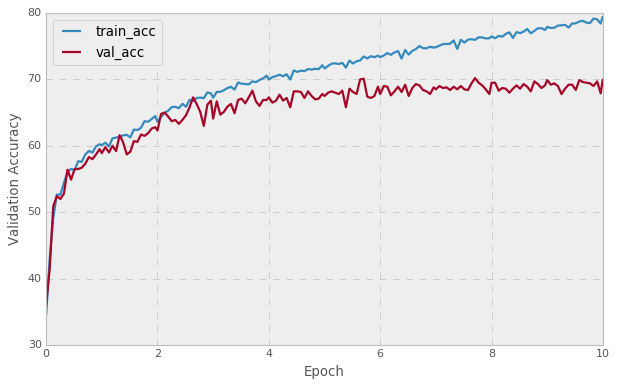

In [269]:
# plot training and test loss for best model - TODO: RERUN LOSS LOWER THAN EXPECTED 
best_rnn_results = load_experiment_log(experiment_name=BEST_RNN_MODEL_NAME, filename=RESULTS_LOG)[0]['results']
plot_single_learning_curve(best_rnn_results)

### Tune CNN 

In [28]:
# instantiate model and optimizer - maxpool 
model = CNN(emb_size=300, hidden_size=50, num_layers=2, fc_out_size=10, num_classes=3, pretrained_weights=pretrained_weights)

# train and evaluate 
results = train_and_eval(model, snli_train_loader, snli_val_loader, learning_rate=0.01, num_epochs=2, print_intermediate=True,
                         save_checkpoint=True, model_name='cnn_test')

Epoch: 0.00, Train Accuracy: 32.79%, Validation Accuracy: 32.60%
Epoch: 0.06, Train Accuracy: 47.27%, Validation Accuracy: 47.60%
Epoch: 0.13, Train Accuracy: 52.05%, Validation Accuracy: 52.20%
Epoch: 0.19, Train Accuracy: 53.28%, Validation Accuracy: 53.00%
Epoch: 0.26, Train Accuracy: 57.72%, Validation Accuracy: 55.30%
Epoch: 0.32, Train Accuracy: 55.33%, Validation Accuracy: 54.70%
Epoch: 0.38, Train Accuracy: 59.27%, Validation Accuracy: 58.50%
Epoch: 0.45, Train Accuracy: 59.40%, Validation Accuracy: 58.10%
Epoch: 0.51, Train Accuracy: 55.92%, Validation Accuracy: 54.10%
Epoch: 0.58, Train Accuracy: 59.27%, Validation Accuracy: 56.90%
Epoch: 0.64, Train Accuracy: 59.66%, Validation Accuracy: 57.10%
Epoch: 0.70, Train Accuracy: 60.79%, Validation Accuracy: 57.70%
Epoch: 0.77, Train Accuracy: 61.32%, Validation Accuracy: 59.60%
Epoch: 0.83, Train Accuracy: 60.39%, Validation Accuracy: 59.30%
Epoch: 0.90, Train Accuracy: 60.43%, Validation Accuracy: 59.80%
Epoch: 0.96, Train Accura

In [92]:
kernel_sizes = [2, 3, 4, 5, 6, 7]

for kernel_size in kernel_sizes: 
    print ("Training with kernel_size = {} ...".format(kernel_size))
    
    # train and evaluate
    results, hyperparams, runtime, _, _, _ = run_experiment(
        train_loader=snli_train_loader, val_loader=snli_val_loader,
        model_type='cnn', hidden_size=100, fc_out_size=500, kernel_size=kernel_size, 
        learning_rate=0.001, num_epochs=10, experiment_name='CNN_kernel_size_10epoch', 
        save_to_log=True, save_checkpoint=False, print_summary=True, print_intermediate=True)

Training with kernel_size = 2 ...


KeyboardInterrupt: 

In [284]:
kernel_sizes_exps = summarize_results(load_experiment_log(experiment_name='CNN_kernel_size_10epoch', filename=RESULTS_LOG))
kernel_sizes_exps[['kernel_size', 'num_epochs', 'runtime', 'val_acc']]

,kernel_size,num_epochs,runtime,val_acc
5,7,10,2970.121420,67.9
2,4,10,3015.023007,67.8
3,5,10,2986.128964,67.5
1,3,10,3066.791935,67.2
0,2,10,3035.196893,67.0
4,6,10,2973.847352,66.8


In [285]:
# BEST_KERNEL_SIZE = 3
# hidden_sizes = [25, 50, 100, 200]
# fc_out_sizes = [100, 200, 300, 500, 750]

for hidden_size in hidden_sizes: 
    for fc_out_size in fc_out_sizes: 
        print ("Training with hidden_size = {} and fc_out_size = {} ...".format(hidden_size, fc_out_size))

        # train and evaluate
        results, hyperparams, runtime, _, _, _ = run_experiment(
            train_loader=snli_train_loader, val_loader=snli_val_loader,
            model_type='cnn', hidden_size=hidden_size, fc_out_size=fc_out_size, kernel_size=BEST_KERNEL_SIZE, 
            learning_rate=0.001, num_epochs=10, experiment_name='CNN_hidden_fc_out_size_10epoch', 
            save_to_log=True, save_checkpoint=False, print_summary=True, print_intermediate=True)

In [286]:
cnn_hidden_fc_out_size_exps = summarize_results(load_experiment_log(experiment_name='CNN_hidden_fc_out_size_10epoch', filename=RESULTS_LOG))
cnn_hidden_fc_out_size_exps[['hidden_size', 'fc_out_size', 'num_epochs', 'runtime', 'val_acc', 'learning_rate']].sort_values(['hidden_size', 'fc_out_size'])

,hidden_size,fc_out_size,num_epochs,runtime,val_acc,learning_rate
0,25,100,10,2726.342484,66.9,0.001
1,25,200,10,2733.828971,66.9,0.001
2,25,300,10,2738.308135,67.8,0.001
3,25,500,10,2746.152028,66.8,0.001
4,25,750,10,2756.853067,67.5,0.001
5,50,100,10,2774.530702,67.1,0.001
6,50,200,10,2786.133219,67.7,0.001
7,50,300,10,2790.517048,68.4,0.001
8,50,500,10,2793.857065,68.9,0.001
9,50,750,10,2806.106836,67.5,0.001


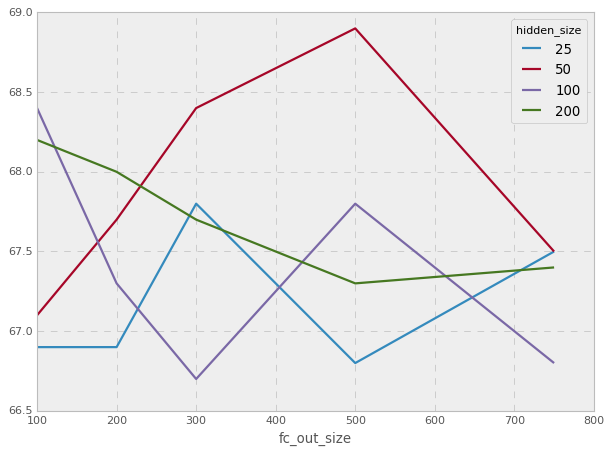

In [288]:
# plot summary results 
pd.pivot_table(cnn_hidden_fc_out_size_exps, values='val_acc', index='fc_out_size', columns='hidden_size').plot();

In [289]:
# best model 
cnn_hidden_fc_out_size_exps[['hidden_size', 'fc_out_size', 'kernel_size','num_epochs', 'runtime', 'val_acc']].sort_values(
    ['val_acc'], ascending=False).head(1)

,hidden_size,fc_out_size,kernel_size,num_epochs,runtime,val_acc
8,50,500,4,10,2793.857065,68.9


# Model Evaluation 

#### Reload Best Models  

In [270]:
# reload best RNN 
best_rnn_model_snli = rnn_model(emb_size=300, num_layers=1, num_classes=3, pretrained_weights=pretrained_weights,
                                hidden_size=BEST_RNN_HIDDEN_SIZE, fc_out_size=BEST_RNN_FC_OUT_SIZE)
checkpoint = torch.load('model_checkpoints/{}.pth.tar'.format(BEST_RNN_MODEL_NAME), map_location=device)
best_rnn_model_snli.load_state_dict(checkpoint)
#checkpoint = torch.load('model_checkpoints/{}.pth.tar'.format(BEST_RNN_MODEL_NAME))
#checkpoint = torch.load('model_checkpoints/{}.pth.tar'.format(BEST_RNN_MODEL_NAME), map_location='cpu')
#torch.load('encoder.pt', map_location=lambda storage, loc: storage)

In [271]:
print(count_parameters(best_rnn_model_snli))
print(best_rnn_model_snli)

684403
rnn_model(
  (embedding1): Embedding(50002, 300)
  (embedding2): Embedding(50002, 300)
  (rnn1): GRU(300, 100, batch_first=True, bidirectional=True)
  (rnn2): GRU(300, 100, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=400, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=3, bias=True)
)


In [212]:
# TODO: reload best CNN

#### Evaluate on SNLI Validation Set 

In [278]:
# retest on SNLI validation set 
val_accuracy, val_predictions, val_labels = test_model(snli_val_loader, best_rnn_model_snli) 
print(val_accuracy)

69.7


#### Evaluate on MNLI Validation Set (Unseen) 

In [279]:
mnli_genres = mnli_train['genre'].unique()
mnli_train['genre'].value_counts()

telephone     4270
slate         4026
travel        3985
government    3883
fiction       3836
Name: genre, dtype: int64

In [280]:
mnli_train.head()

,sentence1,sentence2,label,genre
0,and now that was in fifty one that 's forty years ago that it was already a problem so it 's now uh,It was already a problem forty years ago but now it 's ten times worse !,neutral,telephone
1,Jon could smell baked bread on the air and his stomach rumbled .,Jon smelt food in the air and was hungry .,neutral,fiction
2,it will be like Italian basketball with the uh with with the uh NBA,This type of Italian basketball is nothing like the NBA .,contradiction,telephone
3,well i think that 's about uh that 's about covered it for me so i think i 'll say good-bye and ...,Sorry but we are not done just yet .,contradiction,telephone
4,"Good job tenure , that is -- because in yet another column , she sneers at Sara Davidson for wor...","Dr. Quinn , Medicine Woman , was worked on by Sara Davidson .",entailment,slate


In [281]:
# create data loaders and put in a dictionary 

mnli_data_loaders = {} 
for genre in mnli_genres: 
    # create train loader 
    genre_train = mnli_val[mnli_train['genre'] == genre].copy()
    train_sent1, train_sent2, train_labels = df_to_list(genre_train, token2id)
    train_loader = create_data_loader(train_sent1, train_sent2, train_labels)
    # create val loader 
    genre_val = mnli_val[mnli_val['genre'] == genre].copy()
    val_sent1, val_sent2, val_labels = df_to_list(genre_val, token2id)
    val_loader = create_data_loader(val_sent1, val_sent2, val_labels)
    # return loaders as (train_loader, val_loader) tuple stored as genre's value in dict 
    mnli_data_loaders[genre] = (train_loader, val_loader)

/Users/Gary/anaconda/envs/nlpclass/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [282]:
rnn_eval_results = [] 
for genre in mnli_genres: 
    result ={} 
    result['genre'] = genre 
    val_accuracy, val_predictions, val_labels = test_model(mnli_data_loaders[genre][1], best_rnn_model_snli) 
    result['test_accuracy'] = val_accuracy 
    rnn_eval_results.append(result) 

In [283]:
pd.DataFrame.from_dict(rnn_eval_results)

,genre,test_accuracy
0,telephone,42.686567
1,fiction,47.437186
2,slate,42.315369
3,government,43.110236
4,travel,44.399185


# Model Finetuning